In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the cleaned dataset
data = pd.read_csv('student4.csv')

# Create the target variable 'Y' based on G3
data['Y'] = data['G3'].apply(lambda x: 1 if x >= 10 else 0)

# Drop the original G3 column
data = data.drop('G3', axis=1)

In [4]:
# Binary features to convert to numeric
binary_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 
                   'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

# Map binary features to numeric
binary_mapping = {
    'school': {'GP': 0, 'MS': 1},
    'sex': {'F': 0, 'M': 1},
    'address': {'U': 0, 'R': 1},
    'famsize': {'LE3': 0, 'GT3': 1},
    'Pstatus': {'T': 0, 'A': 1},
    'schoolsup': {'yes': 1, 'no': 0},
    'famsup': {'yes': 1, 'no': 0},
    'paid': {'yes': 1, 'no': 0},
    'activities': {'yes': 1, 'no': 0},
    'nursery': {'yes': 1, 'no': 0},
    'higher': {'yes': 1, 'no': 0},
    'internet': {'yes': 1, 'no': 0},
    'romantic': {'yes': 1, 'no': 0}
}

# Apply the binary mapping
for feature, mapping in binary_mapping.items():
    data[feature] = data[feature].map(mapping)

# Multi-class features to be one-hot encoded
multi_class_features = ['Mjob', 'Fjob', 'reason', 'guardian']

# One-hot encode the multi-class features
onehotencoder = OneHotEncoder(sparse=False)
encoded_features = pd.DataFrame(onehotencoder.fit_transform(data[multi_class_features]), 
                                columns=onehotencoder.get_feature_names_out(multi_class_features))

# Drop the original multi-class features from the dataset
data = data.drop(multi_class_features, axis=1)

# Concatenate the one-hot encoded features back to the dataset
data = pd.concat([data, encoded_features], axis=1)

C:\Users\yasee\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
# List of ordinal features
ordinal_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 
                    'freetime', 'goout', 'Dalc', 'Walc', 'health']

# List of numerical features
numerical_features = ['age', 'absences', 'G1', 'G2']

# Combine ordinal and numerical features for scaling
features_to_scale = ordinal_features + numerical_features

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the combined ordinal and numerical features
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [6]:
# Apply SMOTE to the entire dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(data.drop('Y', axis=1), data['Y'])

# Perform RFE to select top K features
k = 20  # Adjust K as needed
selector = RFE(SVC(kernel='linear'), n_features_to_select=k)
X_res_selected = selector.fit_transform(X_res, y_res)

# Get selected feature names
selected_features = data.columns[selector.get_support(indices=True)]
print("Selected Features:", selected_features)

Selected Features: Index(['school', 'age', 'address', 'Pstatus', 'Fedu', 'higher', 'Walc',
       'health', 'G1', 'G2', 'Y', 'Mjob_at_home', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'reason_course',
       'reason_other', 'reason_reputation', 'guardian_mother'],
      dtype='object')


Average Accuracy: 0.9668414154652687
Fold 1 Confusion Matrix:
 [[106   3]
 [  2 107]]
Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.98       109

    accuracy                           0.98       218
   macro avg       0.98      0.98      0.98       218
weighted avg       0.98      0.98      0.98       218

Fold 2 Confusion Matrix:
 [[106   3]
 [  2 106]]
Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.98       108

    accuracy                           0.98       217
   macro avg       0.98      0.98      0.98       217
weighted avg       0.98      0.98      0.98       217

Fold 3 Confusion Matrix:
 [[108   1]
 [ 10  98]]
Fold 3 Classification Report:
               precision    recall  f1-score   support

           0  

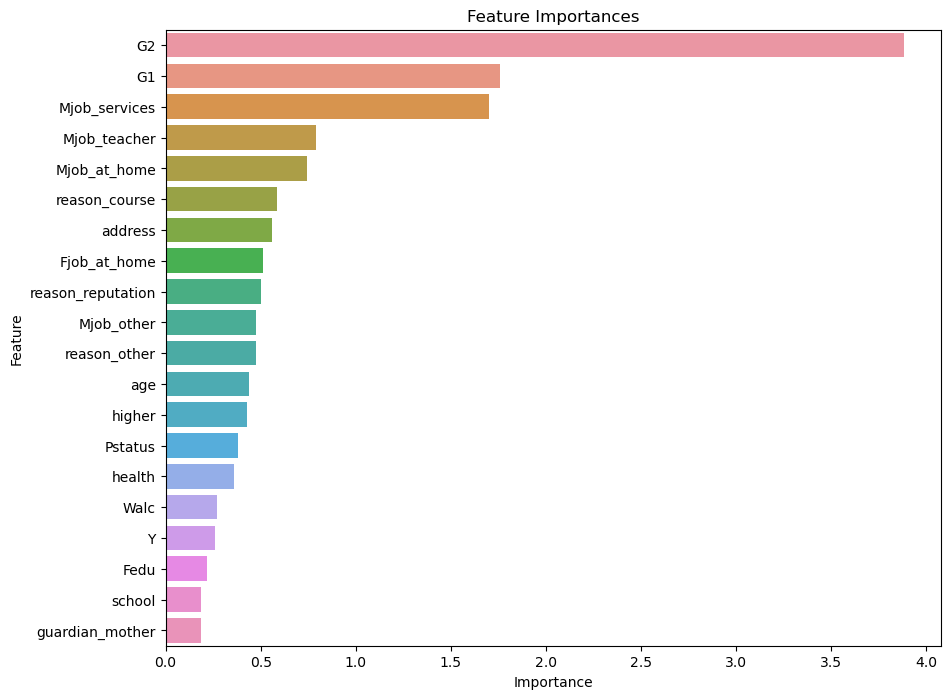

In [7]:
# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
conf_matrices = []
class_reports = []
accuracies = []
feature_importances = np.zeros(X_res_selected.shape[1])

# Cross-validation
for train_index, test_index in skf.split(X_res_selected, y_res):
    X_train, X_test = X_res_selected[train_index], X_res_selected[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    
    # Train an SVM classifier
    svm_model = SVC(kernel='linear', random_state=42, class_weight='balanced')
    svm_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = svm_model.predict(X_test)
    
    # Evaluate the model
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    class_reports.append(classification_report(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))
    
    # Accumulate feature importances
    feature_importances += np.abs(svm_model.coef_[0])

# Average accuracy
average_accuracy = sum(accuracies) / len(accuracies)

# Average feature importances
feature_importances /= skf.get_n_splits()

print("Average Accuracy:", average_accuracy)
for i, (cm, cr) in enumerate(zip(conf_matrices, class_reports)):
    print(f"Fold {i+1} Confusion Matrix:\n", cm)
    print(f"Fold {i+1} Classification Report:\n", cr)

# Print feature importances
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Certainly! Below is a comprehensive report summarizing all the steps and procedures we followed to build, evaluate, and interpret the SVM model for student performance prediction.

---

## Machine Learning Project Report: Student Performance Prediction

### Introduction

This report outlines the steps taken to preprocess data, handle class imbalance, select important features, and build a Support Vector Machine (SVM) model to predict student performance. The procedures include data cleaning, encoding categorical variables, scaling numerical features, applying SMOTE for class balancing, feature selection using RFE, cross-validation, model training and evaluation, and feature importance analysis.

### Data Preprocessing

#### 1. Data Loading
- **Objective**: Load the student performance dataset for preprocessing and analysis.
- **Procedure**: The dataset was loaded using pandas' `read_csv` function.

#### 2. Creating Target Variable
- **Objective**: Create a binary target variable 'Y' based on the final grade (G3).
- **Procedure**: A new column 'Y' was created where students with `G3 >= 10` were labeled as `1` (pass) and those with `G3 < 10` as `0` (fail).

#### 3. Dropping Original Grade Column
- **Objective**: Remove the 'G3' column to prevent data leakage.
- **Procedure**: The 'G3' column was dropped from the dataset.

### Encoding Categorical Variables

#### 4. Encoding Binary Features
- **Objective**: Convert binary categorical features to numerical values.
- **Procedure**: Mappings were defined to convert binary features (e.g., 'yes'/'no', 'U'/'R') to 1/0.

#### 5. One-Hot Encoding Multi-Class Features
- **Objective**: Convert multi-class categorical features to numerical values.
- **Procedure**: One-hot encoding was applied to features like 'Mjob', 'Fjob', 'reason', and 'guardian' using `OneHotEncoder` from sklearn.

### Scaling Numerical and Ordinal Features

#### 6. Identifying Features to Scale
- **Objective**: Scale both ordinal and numerical features for consistency.
- **Procedure**: Ordinal and numerical features were combined into a list for scaling.

#### 7. Applying StandardScaler
- **Objective**: Scale features to have a mean of 0 and standard deviation of 1.
- **Procedure**: StandardScaler from sklearn was applied to the combined list of ordinal and numerical features.

### Handling Class Imbalance

#### 8. Applying SMOTE
- **Objective**: Address class imbalance in the target variable.
- **Procedure**: Synthetic Minority Over-sampling Technique (SMOTE) was applied to generate synthetic samples for the minority class (fail) using the `SMOTE` class from `imblearn`.

### Feature Selection

#### 9. Feature Selection using RFE
- **Objective**: Select the most important features for the model.
- **Procedure**: Recursive Feature Elimination (RFE) was used with an SVM estimator to select the top 20 features.

### Model Training and Evaluation

#### 10. Cross-Validation Setup
- **Objective**: Ensure robust model evaluation.
- **Procedure**: Stratified K-Fold cross-validation with 5 splits was set up using `StratifiedKFold` from sklearn to maintain the class distribution in each fold.

#### 11. Model Training and Evaluation
- **Objective**: Train and evaluate the SVM model.
- **Procedure**: For each fold:
  - Split the data into training and test sets.
  - Train an SVM model with a linear kernel and balanced class weights.
  - Make predictions on the test set.
  - Evaluate the model using confusion matrix, classification report, and accuracy score.
  - Accumulate feature importances from the model coefficients.

### Feature Importance Analysis

#### 12. Aggregating Feature Importances
- **Objective**: Determine the average importance of each feature.
- **Procedure**: The absolute values of model coefficients were averaged across all folds to obtain the final feature importances.

#### 13. Visualization
- **Objective**: Visualize the importance of each feature.
- **Procedure**: A bar plot was generated using `matplotlib` and `seaborn` to visualize feature importances, with features sorted by their importance.

### Results

#### Model Performance
- **Average Accuracy**: 96.68%
- **Fold-wise Performance**: Consistently high precision, recall, and F1-scores across all folds.

#### Key Features
- **Top Features**: G2, G1, Mjob_services, Mjob_teacher, etc.
- **Insights**: Academic performance, parental influence, personal health, and motivation are significant predictors of student outcomes.

### Conclusion

The SVM model demonstrated excellent performance in predicting student performance, with academic grades and certain parental and personal factors being the most influential features. The feature importance analysis provided actionable insights that can guide educational interventions and policies.

---

### Attached Files
- `student4.csv`: Original dataset.
- `student4_final_scaled.csv`: Processed dataset with scaled features.
- `Untitled.ipynb`: Jupyter notebook containing all code and analysis steps.

If you have any further questions or need additional analysis, please let me know!

---

This report provides a comprehensive overview of the project, outlining each step and the rationale behind it. If you need the report in a specific format or have any additional requirements, please let me know!